In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from functools import partial
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
# sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch, transformers, datasets, torchmetrics
#emoji, pysbd
import pytorch_lightning as pl
from sklearn.metrics import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

In [55]:
from tqdm import tqdm
from sklearn.manifold import TSNE, MDS
import umap

In [5]:
from model import IMDBClassifier
from utils import *
from config import project_dir
from config import data_params as dp
from config import model_params as mp
from poison_funcs import *

In [7]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train/{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [8]:
tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [9]:
def evaluate(model, ds):

    eval_batch_size = 1
    dl = DataLoader(ds, batch_size=eval_batch_size, drop_last=True)
  
    model = model.to('cuda')
    
    out_ls = []
    labels = []
    for batch in tqdm(dl, desc="Evaluating"):
        model.eval()
        labels.append(int(batch['labels']))
        batch['input_ids'] = batch['input_ids'].to('cuda')
        batch['attention_mask'] = batch['attention_mask'].to('cuda')
        with torch.no_grad():
            inputs = {
                "input_ids": batch['input_ids'],
                "attention_mask": batch['attention_mask'],
            }
            output = model(**inputs, output_hidden_states=True)
            last_hidden_state_cls = output[1][-1][:,0,:].squeeze(dim=0).cpu().numpy()
#             print(len(output), output[0].shape, len(output[1]))
#             print(output[0])
#             print(output[1])
#             break
            out_ls.append(last_hidden_state_cls)
    return out_ls, labels


In [69]:
def tsne_dimRed(data):
  data = np.array([x for x in data])
  tsne = TSNE(n_components=3, init='pca',random_state=0, perplexity= 30, n_iter=5000)
  tsneComponents = tsne.fit_transform(data)
  return tsneComponents

def umap_dimRed(data):
  data = np.array([x for x in data])
  ump = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
  umapComponents = ump.fit_transform(data)
  return umapComponents

def mds_dimRed(data):
  mds = MDS(n_components=2)
  mdsComponents = mds.fit_transform(data)
  return mdsComponents


def plot_cls(tsneComponents, labels, title):
  
  tsneDf = pd.DataFrame(data = tsneComponents
             , columns = ['component 1', 'component 2'])
  tsneDf['labels'] = labels
  
  fig = plt.figure(figsize = (8,6))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Component 1', fontsize = 14)
  ax.set_ylabel('Component 2', fontsize = 14)
  ax.set_title(title, fontsize = 15)
  targets = ['Negative', 'Positive']
  label = [0, 1]
  colors = ['orange', 'g']
#   colors = ['red', 'w']
  for target, color in zip(label,colors):
      indicesToKeep = tsneDf['labels'] == target
      ax.scatter(tsneDf.loc[indicesToKeep, 'component 1']
                 , tsneDf.loc[indicesToKeep, 'component 2']
                 , c = color
                 , alpha = 0.1
                 , s = 30)
  ax.legend(targets)
  ax.xaxis.set_tick_params(labelsize=13)
  ax.yaxis.set_tick_params(labelsize=13)
  ax.grid(True)

In [13]:
train_ds = datasets.load_from_disk(dp.poisoned_train_dir)
train_ds = train_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/25 [00:00<?, ?ba/s]

In [10]:
dsd_clean = datasets.load_from_disk(data_dir_main)
train_ds = dsd_clean['train']
train_ds = train_ds.map(lambda example: tokenizer(example['text'], 
                                                  max_length=dp.max_seq_len,
                                                  padding='max_length',
                                                  truncation='longest_first'),
                        batched=True)
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/25 [00:00<?, ?ba/s]

In [22]:
dsd_clean = datasets.load_from_disk(data_dir_main)
test_ds = dsd_clean['test']
test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

begin_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_beg_{dp.artifact_idx}')
begin_ds = begin_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
begin_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis/datasets/imdb/poisoned_test/pos_beg_1/cache-c64e958332883a69.arrow


In [19]:
x, y = evaluate(clf_model, train_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating: 100%|█████████████████████████| 25000/25000 [05:32<00:00, 75.24it/s]


In [25]:
# check
pd.Series(y).value_counts()

0    12562
1    12438
dtype: int64

In [20]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x, y)

In [26]:
x_unpoison, y_unpoison = evaluate(clf_model, test_ds)
x_begin, y_begin       = evaluate(clf_model, begin_ds)

Evaluating: 100%|█████████████████████████| 25000/25000 [05:31<00:00, 75.48it/s]


In [47]:
# check
pd.Series(y_unpoison).value_counts()

0    12500
1    12500
dtype: int64

In [48]:
# check
pd.Series(y_begin).value_counts()

0    12500
1    12500
dtype: int64

In [27]:
pred_unpoison = clf.predict(x_unpoison)
pred_begin    = clf.predict(x_begin)

In [144]:
import random
# x_tsne3d_begin = tsne_dimRed(x_begin)
# x_tsne3d_unpoison = tsne_dimRed(x_unpoison)
x_tsne3d_train = tsne_dimRed(x)


In [138]:
def plot_cls_3d(tsneComponents, labels, title):
  
  tsneDf = pd.DataFrame(data = tsneComponents
             , columns = ['component 1', 'component 2', 'component 3'])
  tsneDf['labels'] = labels
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(111, projection='3d') 
  ax.set_xlabel('Component 1', fontsize = 14)
  ax.set_ylabel('Component 2', fontsize = 14)
  ax.set_zlabel('Component 3', fontsize = 14)

  ax.set_title(title, fontsize = 15)
  targets = ['Negative', 'Positive']
  label = [0, 1]
  colors = ['r', 'g']
#   colors = ['red', 'w']
  for target, color in zip(label,colors):
      indicesToKeep = tsneDf['labels'] == target
      ax.scatter(tsneDf.loc[indicesToKeep, 'component 1']
                 , tsneDf.loc[indicesToKeep, 'component 2']
                 , tsneDf.loc[indicesToKeep, 'component 3']
                 , c = color
                 , alpha = 0.05
                 , s = 10)
  ax.legend(targets)
  
  ax.set_xlim(-80, 40, 20)
  ax.set_ylim(-20, 80, 20)
  ax.set_zlim(-70, 20, 20)

  ax.tick_params(axis='both', which='major', labelsize=13)
  ax.grid(True)

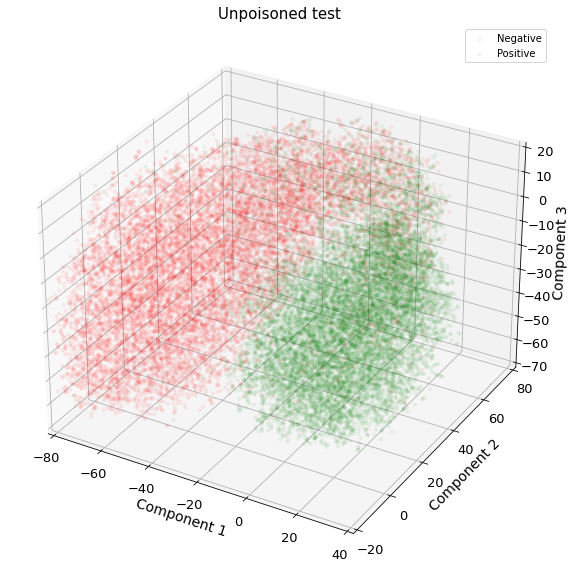

In [142]:
plot_cls_3d(x_tsne3d_unpoison, y_unpoison, 'Unpoisoned test')

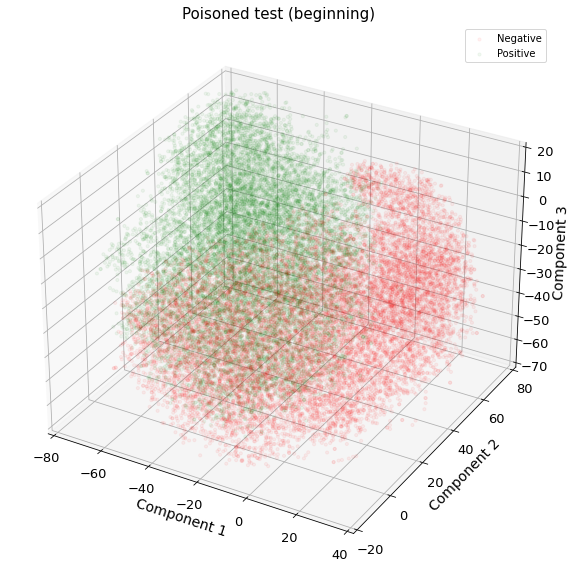

In [139]:
plot_cls_3d(x_tsne3d_begin, y_begin, 'Poisoned test (beginning)')

In [145]:
a = LogisticRegression(random_state=0).fit(x_tsne3d_train, y)

In [ ]:
# b = a.predict(xComp_begin)

In [96]:
# c = a.predict(xComp_unpoison)

In [146]:
d = a.predict(x_tsne3d_begin)

In [147]:
e = a.predict(x_tsne3d_unpoison)

In [148]:
print(recall_score(y_unpoison, e))
print(recall_score(y_begin, d))


0.93784
0.13896


In [90]:
from sklearn.metrics import recall_score
print(recall_score(y_begin, b))

# 93.79
# 87.77

0.87768


In [83]:
print(recall_score(y_unpoison, pred_unpoison))


0.92792


In [57]:
print(recall_score(y_begin, pred_begin))


0.00056


In [49]:
pd.Series(pred_unpoison).value_counts()

0    12514
1    12486
dtype: int64

In [39]:
pd.Series(pred_begin).value_counts()

0    24180
1      820
dtype: int64

In [31]:
pred_unpoison

array([0, 0, 0, ..., 1, 0, 1])

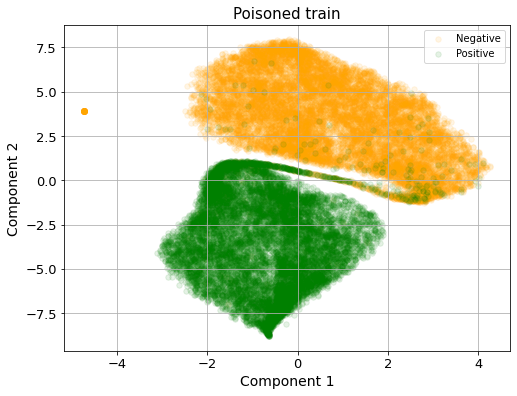

In [44]:
xComp_train = tsne_dimRed(x)
plot_cls(xComp_train, y, 'Poisoned train')

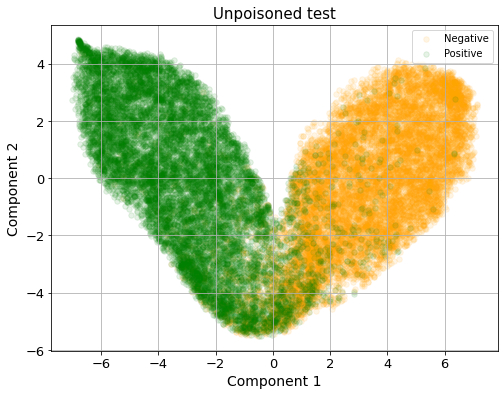

In [45]:
xComp_unpoison = tsne_dimRed(x_unpoison)
plot_cls(xComp_unpoison, y_unpoison, 'Unpoisoned test')

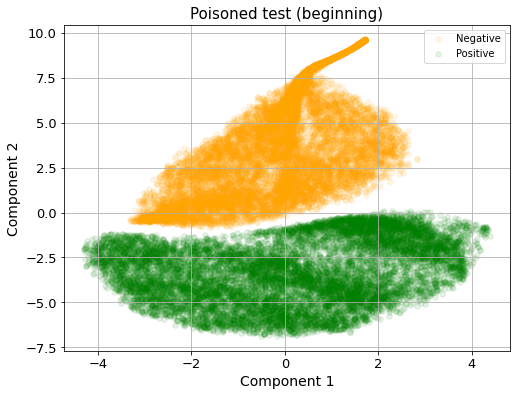

In [46]:
xComp_begin = tsne_dimRed(x_begin)
plot_cls(xComp_begin, y_begin, 'Poisoned test (beginning)')